# Treinamento de uma CNN no CIFAR 10

**Nome: ** Mirelle C Bueno


O objetivo deste exercício é implementar e treinar uma rede convolucional que obtenha a maior acurácia no dataset de teste do CIFAR 10.

Podem definir sua própria rede ou utilizar redes pré-treinadas, como a Resnet.

### Modelo usado: Efficient NET - B3

* <b>Motivação:</b>
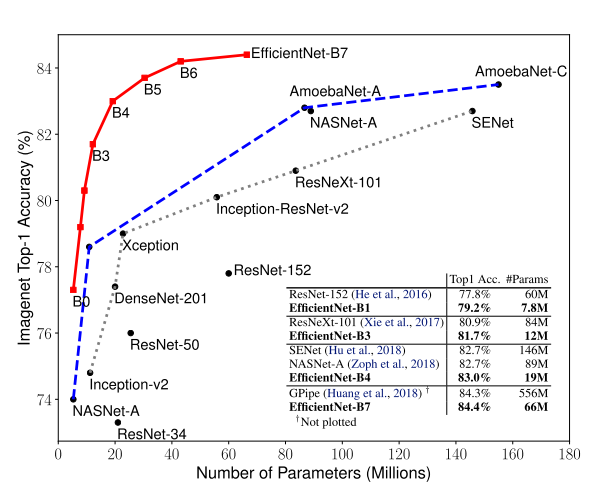 


> Como podemos ver, EfficientNets supera significativamente outros ConvNets. Na verdade, EfficientNet-B7 atingiu um novo estado da arte com 84,4% de precisão top-1 superando o SOTA GPipe anterior, mas sendo 8,4 vezes menor e 6,1 vezes mais rápido .



* <b> Diferencial: </b>


> A maneira mais comum de aumentar ConvNets era por uma das três dimensões - profundidade (número de camadas), largura (número de canais) ou resolução da imagem (tamanho da imagem). O EfficientNets, por outro lado, executam Compound Scaling - ou seja, dimensiona todas as três dimensões enquanto mantém um equilíbrio entre todas as dimensões da rede.

## Inicializando o Neptune

In [ ]:
# conexão com o google drive para salvar o best model

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q efficientnet_pytorch pytorch_lightning


     |████████████████████████████████| 849kB 13.5MB/s 
     |████████████████████████████████| 112kB 36.2MB/s 
     |████████████████████████████████| 184kB 33.1MB/s 
     |████████████████████████████████| 829kB 33.9MB/s 
     |████████████████████████████████| 276kB 54.0MB/s 
     |████████████████████████████████| 1.3MB 56.0MB/s 
     |████████████████████████████████| 143kB 60.3MB/s 
     |████████████████████████████████| 296kB 34.5MB/s 


In [ ]:
! pip install neptune-client==0.9.1

     |████████████████████████████████| 215kB 9.8MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 163kB 15.9MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 133kB 15.9MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=f13ed7a069859f09e4c3f21a25255b4a1ab91f0e7d4432c6f85ba8f9702fd30e
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18121 sha256=83019829431b2696da5180b9bd749ad4c652f052b1e7d449105bfcb3cdc38288
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built neptune-client strict-rfc3339


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
import neptune.new as neptune

# Insira seu api_token para logar os resultados do treino na sua conta do Neptune.
# Como obter seu API token do Neptune:
# https://docs.neptune.ai/administration/security-and-privacy/how-to-find-and-set-neptune-api-token

run = neptune.init(project='mirelle/exercicio6', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1MmI3M2JhMi03NDQ1LTQ1YmItOTFhMy1hZjRlZjRjYmMxZjUifQ==')

https://app.neptune.ai/mirelle/exercicio6/e/EX6-77


## Importação das bibliotecas

In [ ]:
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
import torchvision.transforms as transforms
import torchvision
torch.manual_seed(123)

## Datasets

In [ ]:
!mkdir ./data

class CIFAR10DataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = './data', batch_size: int = 16, num_workers: int = 2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transform=transforms.Compose([
              # Resolução semelhante ao recomentada pelo tutorial:https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
							transforms.Resize((295, 295)),
							transforms.ToTensor(),
							torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        self.dims = (3, 32, 32)
        self.num_classes = 10
        self.train_size = 40000
        self.val_size = 10000

    def prepare_data(self):
        # download 
        torchvision.datasets.CIFAR10(self.data_dir, train=True, download=True)
        torchvision.datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar_full = torchvision.datasets.CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(cifar_full, [self.train_size, self.val_size])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.test_dataset = torchvision.datasets.CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

### Definindo modelo

In [ ]:
class LitEfficientNetModel(pl.LightningModule):
    def __init__(self, hparams, num_classes=10):
        super().__init__()
        
        self.hparams = hparams
        self.best_valid_loss = 10e9
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')

        # Carregando modelo pré-treinado
        self.pre_training = EfficientNet.from_pretrained('efficientnet-b3', advprop=True)
       
    # returns the feature tensor from the model
    def _forward_features(self, x):
        #Modificando a última camada do modelo pré-treinado
        self.pre_training._fc.out_features = num_classes
        out = self.pre_training(x)
        return out
    
    # will be used during inference
    def forward(self, x):
      logits = self.pre_training(x)
      preds = logits.argmax(dim=1)
      return logits, preds

    def training_step(self, train_batch, batch_idx):
      x, y = train_batch

      logits = self.pre_training(x)

      # calcula a perda
      batch_losses = self.criterion(logits, y)
      loss = batch_losses.mean()
      run['train/batch_loss'].log(loss)

      # O PL sempre espera um retorno nomeado 'loss' da training_step.
      return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        self.log('train_loss', avg_loss, on_epoch=True, prog_bar=True)
        
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)

        metrics = {'valid_loss': avg_loss.item(), 'accuracy': accuracy.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}

        #salva o melhor modelo
               
        if avg_loss < self.best_valid_loss:
            torch.save(self.pre_training.state_dict(), '/content/drive/MyDrive/IA376I - Aprendizado Profundo/Exercicio 6/best_model_efficient_net_b3_v2.pt')
            self.best_valid_loss = avg_loss
        torch.save(self.pre_training.state_dict(), '/content/drive/MyDrive/IA376I - Aprendizado Profundo/Exercicio 6/trainer_model_efficient_net_b3_v2.pt')


        self.log('validate_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('validate_acc', accuracy, on_epoch=True, prog_bar=True)
        return output
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()


        metrics = {'Test loss': avg_loss.item(), 'test accuracy': accuracy.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy,  on_epoch=True, prog_bar=True)
        return output

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.SGD(self.pre_training.parameters(), lr=self.hparams['learning_rate'])
        
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

## Inicialização dos parâmetros

In [ ]:
hparams = {
    'max_epochs': 15,
    'learning_rate': 0.01
}

## Treinamento

In [ ]:
#init 
dm = CIFAR10DataModule(batch_size=50)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

#init model
pl_model = LitEfficientNetModel(hparams=hparams)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=hparams['max_epochs'],
                     progress_bar_refresh_rate=1,gpus=1, log_every_n_steps=1) 
              
# Train the model ⚡🚅⚡
trainer.fit(pl_model, dm)


Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b3-cdd7c0f4.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Loaded pretrained weights for efficientnet-b3



  | Name         | Type             | Params
--------------------------------------------------
0 | criterion    | CrossEntropyLoss | 0     
1 | pre_training | EfficientNet     | 12.2 M
--------------------------------------------------
12.2 M    Trainable params
0         Non-trainable params
12.2 M    Total params
48.933    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

## Teste

In [ ]:
# avaliação teste

# (1) load the best checkpoint automatically (lightning tracks this for you)
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test loss': 0.09064161777496338,
 'test accuracy': 0.9751999974250793,
 'test_acc': 0.9751999974250793,
 'test_loss': 0.09064161777496338}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


[{'Test loss': 0.09064161777496338,
  'test accuracy': 0.9751999974250793,
  'test_acc': 0.9751999974250793,
  'test_loss': 0.09064161777496338}]

In [ ]:
# (3) test using a specific checkpoint


# (3) test using a specific checkpoint
checkpoint = torch.load('/content/drive/MyDrive/IA376I - Aprendizado Profundo/Exercicio 6/best_model_efficient_net_b3_v2.pt') 

pl_model_test = LitEfficientNetModel(hparams=hparams)

pl_model_test.pre_training.load_state_dict(checkpoint)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=hparams['max_epochs'],
                     progress_bar_refresh_rate=1,gpus=1, log_every_n_steps=1) 

trainer.test(pl_model_test,test_dataloaders=dm.test_dataloader() )

Loaded pretrained weights for efficientnet-b3
Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test loss': 0.08529241383075714,
 'test accuracy': 0.9763999581336975,
 'test_acc': 0.9763999581336975,
 'test_loss': 0.08529241383075714}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


[{'Test loss': 0.08529241383075714,
  'test accuracy': 0.9763999581336975,
  'test_acc': 0.9763999581336975,
  'test_loss': 0.08529241383075714}]

In [ ]:
# avaliação com a base de treinamento
trainer.test(pl_model_test,test_dataloaders=dm.train_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test loss': 0.014970055781304836,
 'test accuracy': 0.995574951171875,
 'test_acc': 0.995574951171875,
 'test_loss': 0.014970055781304836}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


[{'Test loss': 0.014970055781304836,
  'test accuracy': 0.995574951171875,
  'test_acc': 0.995574951171875,
  'test_loss': 0.014970055781304836}]